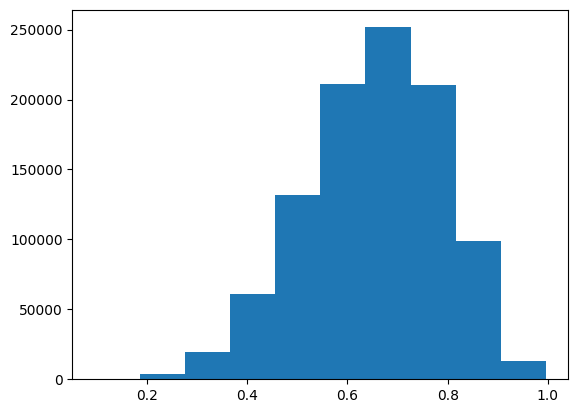

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
random.seed(42)
np.random.seed(42)

a = 7.541
b = 4.0
num_samples = 1000000 # Миллион

data = np.random.beta(a, b, size=num_samples) # Генерация даты по бэта-функции
np.savetxt("beta.csv", data, delimiter=",")

X = pd.read_csv('beta.csv').values # Массив данных
mu = 0.001 # Мю
N = len(X) # Длина массива

plt.hist(X)
plt.show()

In [2]:
alpha_p = a # Параметры априорного распределения
beta_p = 1.0

alpha_q = a # Известное значение alpha
initial_beta_q = 1.0 # Начальное значение для beta_q

Бэта-функция - это функция, характеризующаяся двумя переменными a (альфа) и b (бэта), а, в определены на (0; +бесконечность)

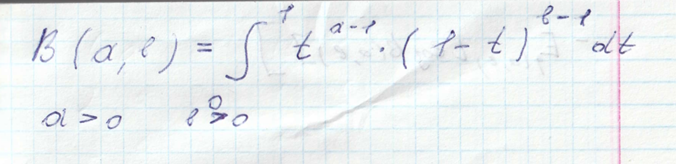

ELBO для бэта-функции имеет следующий вид:

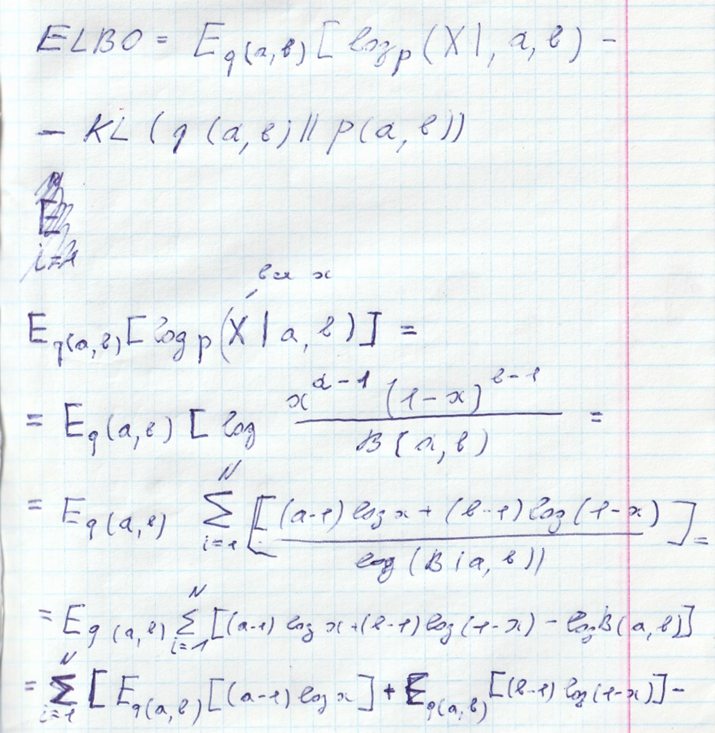

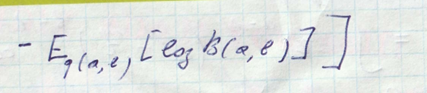

Аналогично ELBO для фунции нормального распределения ELBO для бэта-функции представляет собой разность мат ожиданий плотности вероятности и дивергенции. Для того, чтобы написать алгоритм необходимо по максимумум оптимизировать формулу. Выше представлено мат. ожидание от логарифма плотности вероятности. 

Бэта-функцию можно вывести из гамма функции (функция Эйлера), соответственно логарифм можно брать из следующего равенства (такое решение можно обосновать тем, что логарифм от бэта функцию в качестве функции реализован в библиотеки math, которая и будет использована)

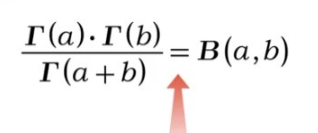

In [3]:
# Функция логарифма бэта-функции

def betaln(a, b):
    return math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b)

Далее необходимо найти дивергенцию

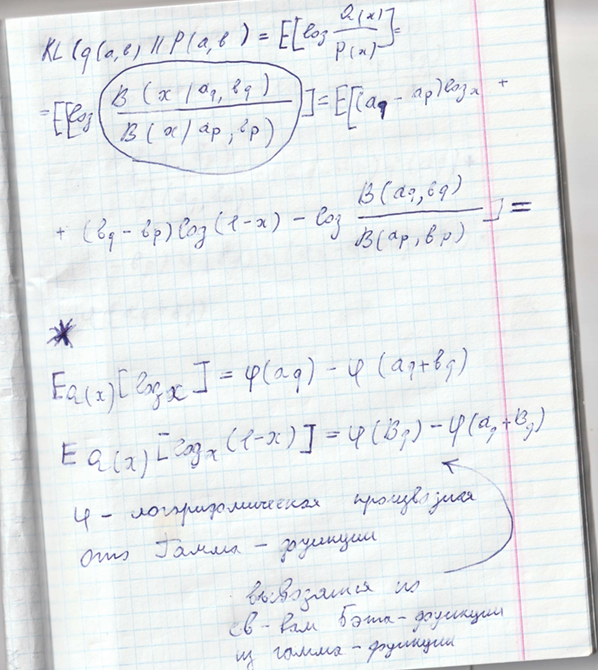

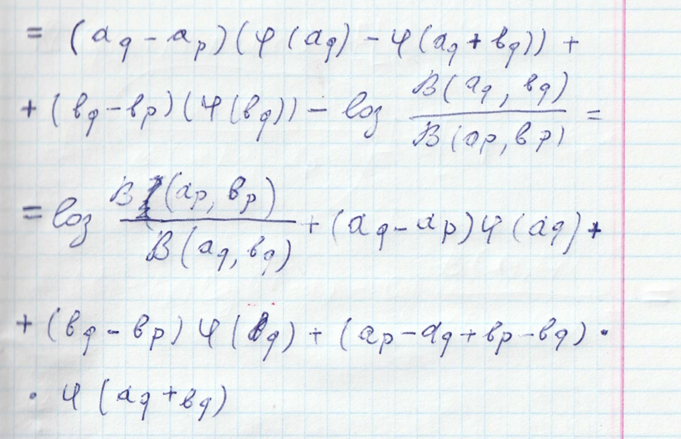

Диагамма функция имеет следующую формулу (Источник: https://en.wikipedia.org/wiki/Digamma_function)

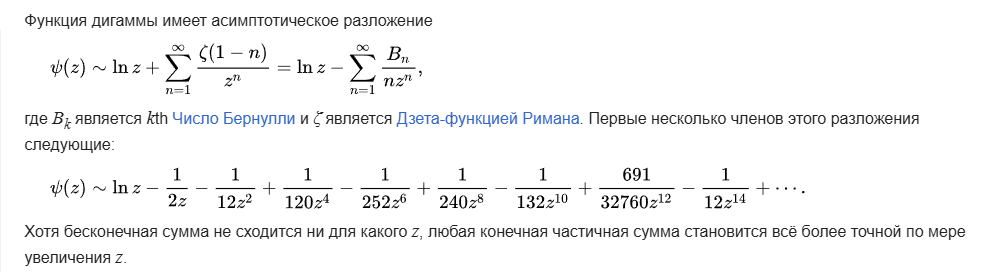

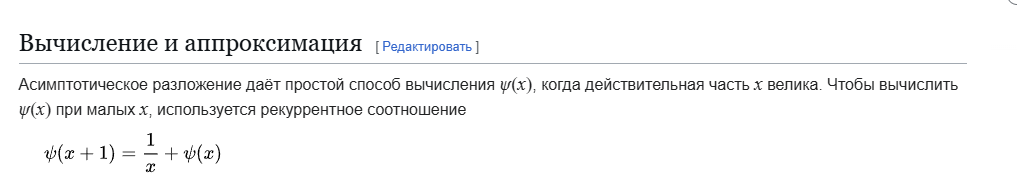

In [4]:
def digamma(x): # Диагамма-функция (Логарифмическая производная от гамма функции)
 
    if x < 6:
        return digamma(x + 1) - 1 / x # Если x < 6 - аппроксимируем
    
    result = math.log(x) - 1 / (2 * x) - 1 / (12 * x**2) + 1 / (120 * x**4) # Асимптотическое разложение для x >= 6
    return result

Теперь можно составить ELBO по бэта-функции:

In [5]:
# Функция для вычисления ELBO (только для beta_q)
def elbo(beta_q):

    # Ожидаемое значение логарифма правдоподобия
    E_log_likelihood = np.sum((alpha_q - 1) * np.log(X) + (beta_q - 1) * np.log(1 - X) - betaln(alpha_q, beta_q))

    # KL-дивергенция
    kl_div = (betaln(alpha_q, beta_q) - betaln(alpha_p, beta_p) \
             + (alpha_q - alpha_p) * digamma(alpha_q) \
             + (beta_q - beta_p) * digamma(beta_q) \
             + (alpha_p - alpha_q + beta_p - beta_q) * digamma(alpha_q + beta_q))

    return -(E_log_likelihood - kl_div)

Зная функцию ELBO нужно брать брать дифференциал по коэффициенту бэта (по примеру альфу мы знаем) и реализовывать градиентный подъем для оптимизации параметра (для максимизации ELBO)

Подбор градиента реализовал через ADAM (я на самом деле пробовал и Ada, и лёрнинг рейт с затуханием, и адаптивный лёрнинг рейт, но из-за того, что я начал пытаться подниматься по градиенту очень поздно, у меня почти сразу сработал ADAM, а его я пробовал последним)

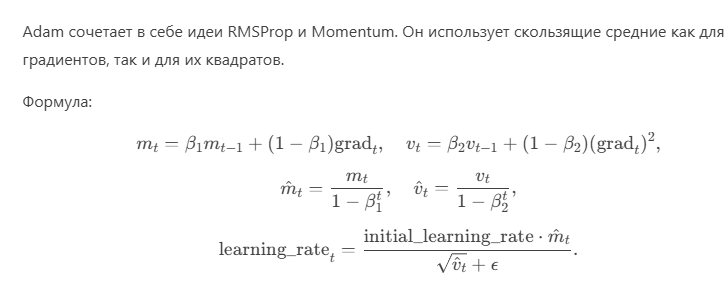

In [6]:
def gradient_elbo_beta(beta_q, X, alpha_q, alpha_p, beta_p): # Градиент (производная) по бэте 

    grad_E_log_likelihood = np.sum(np.log(1 - X)) - N * (digamma(beta_q) - digamma(alpha_q + beta_q))

    grad_kl_div = (digamma(beta_q) - digamma(beta_p)
                 + (digamma(alpha_q + beta_q) - digamma(alpha_p + beta_p)))

    grad_elbo = grad_E_log_likelihood - grad_kl_div # Сам градиент ELBO
    return grad_elbo

def custom_minimize(initial_beta_q, X, alpha_q, alpha_p, beta_p, initial_learning_rate=0.01, max_iter=10000, mu=mu, epsilon=1e-8, beta1 = 0.6, beta2 = 0.84, m = 0, v = 0): # Аналог minimize с использованием градиентного спуска 

    global beta_q, list_of_betas, beta_q_new

    list_of_betas = list()
    list_of_elbos = list()
    list_of_grads = list()

    beta_q = initial_beta_q

    elbo_prev = np.inf  # Предыдущее значение ELBO (минус беконечность)
        
    for i in range(max_iter):
        
        grad = gradient_elbo_beta(beta_q, X, alpha_q, alpha_p, beta_p) # Вычисляем градиент


        m = beta1 * m + (1 - beta1) * grad # Adam
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))
        learning_rate = initial_learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        
        beta_q_new = beta_q + learning_rate

        elbo_new = -(elbo(beta_q_new)) # Вычисляем  ELBO

        if abs(beta_q_new - beta_q) <= mu:
            print(f"Сходимость достигнута на итерации {i}.") # Проверка сходимости
            break

        beta_q = beta_q_new
        list_of_betas.append(beta_q_new)
        list_of_elbos.append(elbo_new)
        list_of_grads.append(grad)
    
    return beta_q, list_of_betas, list_of_elbos, list_of_grads

In [7]:
beta_q_opt, list_of_betas, list_of_elbos, list_grads = custom_minimize(initial_beta_q, X, alpha_q, alpha_p, beta_p)

Сходимость достигнута на итерации 326.


In [8]:
from scipy.optimize import minimize

c = minimize(elbo, initial_beta_q)

C:\Users\Илья\AppData\Local\Temp\ipykernel_7584\1923301769.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b)
C:\Users\Илья\AppData\Local\Temp\ipykernel_7584\4016337427.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = math.log(x) - 1 / (2 * x) - 1 / (12 * x**2) + 1 / (120 * x**4) # Асимптотическое разложение для x >= 6
C:\Users\Илья\AppData\Local\Temp\ipykernel_7584\1923301769.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this op

In [9]:
print('Результат minimize из scipy;', c.x[0])

Результат minimize из scipy; 3.999338643116509


In [10]:
print('Полученная beta алгоритмом вариационного вывода:', beta_q_opt)

Полученная beta алгоритмом вариационного вывода: 3.9993426803950554


In [17]:
1 - beta_q_opt / 4.0

0.00016432990123615987

In [11]:
a_new = a
b_new = beta_q_opt

X_new = np.random.beta(a_new, b_new, size=num_samples) # num_samples - миллион (как и в искомом)

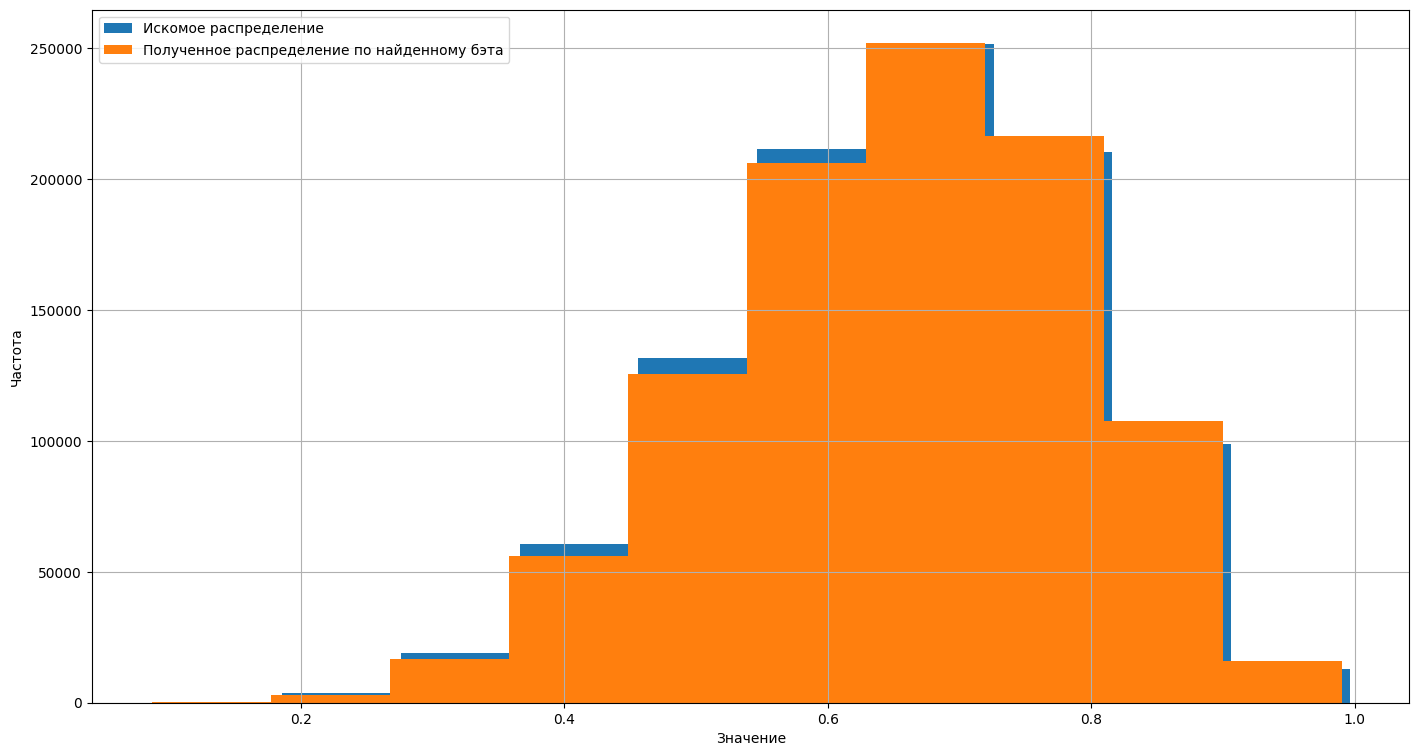

In [12]:
plt.figure(figsize=(17, 9))
plt.hist(X, label='Искомое распределение')
plt.hist(X_new, label='Полученное распределение по найденному бэта')
plt.legend()
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

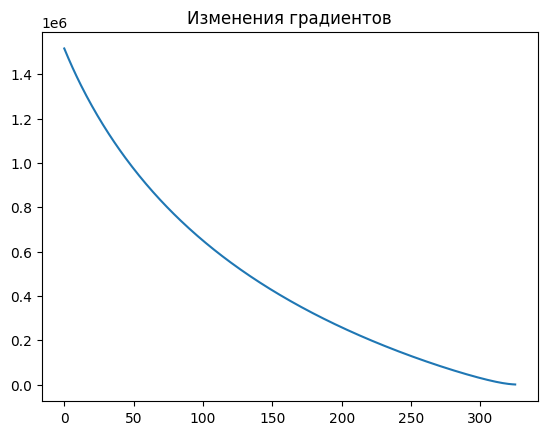

In [13]:
plt.plot(list_grads)
plt.title('Изменения градиентов')
plt.show()

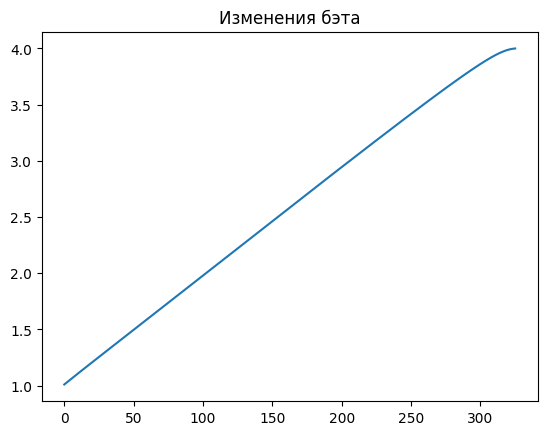

In [14]:
plt.plot(list_of_betas)
plt.title('Изменения бэта')
plt.show()

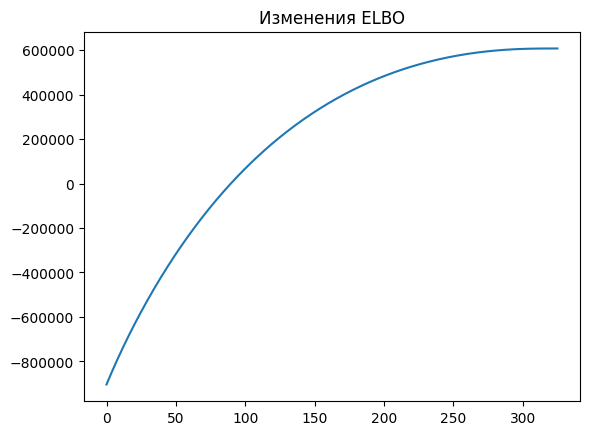

In [15]:
plt.plot(list_of_elbos)
plt.title('Изменения ELBO')
plt.show()